In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from matplotlib.pyplot import figure

import os
import pickle as pkl

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb

In [2]:
ddos_files = []
DATA_PATH = os.path.join(os.getcwd(), 'kaggle_data')

for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if filename.endswith('.parquet'):
            data_fp = os.path.join(dirname, filename)
            ddos_files.append(data_fp)
            print(data_fp)

# remove portmap data
ddos_files.remove(os.path.join(DATA_PATH, 'Portmap-training.parquet'))

g:\UVM\CS3540\_fp\kaggle_data\DNS-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\LDAP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\LDAP-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\MSSQL-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\MSSQL-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\NetBIOS-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\NetBIOS-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\NTP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Portmap-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\SNMP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Syn-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Syn-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\TFTP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDP-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDPLag-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDPLag-training.parquet


In [56]:
ddos_df = pd.concat([pd.read_parquet(dfp) for dfp in ddos_files], ignore_index=True)

ddos_df['Fwd Header Length'] = ddos_df['Fwd Header Length'].apply(lambda x: -1000 if x <= -10000 else x)
ddos_df['Fwd Seg Size Min'] = ddos_df['Fwd Seg Size Min'].apply(lambda x: -1000 if x <= -10000 else x)

ddos_df['Fwd Header Length'] = ddos_df['Fwd Header Length'].apply(lambda x: 1000 if x >= 10000 else x)
ddos_df['Fwd Seg Size Min'] = ddos_df['Fwd Seg Size Min'].apply(lambda x: 1000 if x >= 10000 else x)

ddos_df['Label'] = ddos_df['Label'].replace('UDP-lag', 'UDPLag') # rename since they are the same thing

drop_cols = {
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'FIN Flag Count',
    'PSH Flag Count',
    'ECE Flag Count',
    'Fwd Avg Bytes/Bulk',
    'Fwd Avg Packets/Bulk',
    'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk',
    'Bwd Avg Packets/Bulk',
    'Bwd Avg Bulk Rate'
}

for col in drop_cols:
    ddos_df.drop(col, axis=1, inplace=True)

In [57]:
def zscore_normalization(df, col_name):
    mean = df[col_name].mean()
    std = df[col_name].std()
    df[col_name] = (df[col_name] - mean) / std

    return df

In [58]:
cols = ddos_df.columns
cols = cols.drop('Label')
cols = cols.drop('Protocol') # Don't normalize the protocol value
for col in cols:
    ddos_df = zscore_normalization(ddos_df, col)

# Encode labels and separate features and target
label_encoder = LabelEncoder()
label_encoder.fit(ddos_df['Label'].unique())

ddos_df['Label'] = label_encoder.transform(ddos_df['Label'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for label, encoded_value in label_mapping.items():
    print(f"Label: {label} - Encoded Value: {encoded_value}")

Label: Benign - Encoded Value: 0
Label: DrDoS_DNS - Encoded Value: 1
Label: DrDoS_LDAP - Encoded Value: 2
Label: DrDoS_MSSQL - Encoded Value: 3
Label: DrDoS_NTP - Encoded Value: 4
Label: DrDoS_NetBIOS - Encoded Value: 5
Label: DrDoS_SNMP - Encoded Value: 6
Label: DrDoS_UDP - Encoded Value: 7
Label: LDAP - Encoded Value: 8
Label: MSSQL - Encoded Value: 9
Label: NetBIOS - Encoded Value: 10
Label: Syn - Encoded Value: 11
Label: TFTP - Encoded Value: 12
Label: UDP - Encoded Value: 13
Label: UDPLag - Encoded Value: 14
Label: WebDDoS - Encoded Value: 15


In [95]:
ddos_X = ddos_df.drop(columns=['Label'])
ddos_y = ddos_df['Label']

X_split, X_val, y_split, y_val = train_test_split(ddos_X, ddos_y, test_size=0.6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.2, random_state=87)

In [7]:
xgb_model = xgb.XGBClassifier(
    objective = 'multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    # n_estimators = 100,
    # max_depth = 6,
    # learning_rate = 0.1,
    random_state = 42,
)

In [8]:
# Doesn't work
xgb_model.fit(X_train, y_train)

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=16, num_parallel_tree=None, ...)

# LightGBM

In [9]:
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = lgb.Dataset(data=X_test, label=y_test)
val_data = lgb.Dataset(data=X_val, label=y_val)

In [77]:
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'random_state': 42,
}

In [ ]:
rounds = 100
lgb_model = lgb.train(params=params,
                      train_set=train_data,
                      num_boost_round=rounds,
                      valid_sets=[test_data],
                      )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14049
[LightGBM] [Info] Number of data points in the train set: 136404, number of used features: 65
[LightGBM] [Info] Start training from score -1.528658
[LightGBM] [Info] Start training from score -4.764618
[LightGBM] [Info] Start training from score -5.700884
[LightGBM] [Info] Start training from score -4.200223
[LightGBM] [Info] Start training from score -1.256479
[LightGBM] [Info] Start training from score -6.592268
[LightGBM] [Info] Start training from score -5.080496
[LightGBM] [Info] Start training from score -3.714151
[LightGBM] [Info] Start training from score -5.400129
[LightGBM] [Info] Start training from score -3.904020
[LightGBM] [Info] Start training from score -6.485838
[LightGBM] [Info] Start training from score -2.1520

In [92]:
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=len(label_encoder.classes_), metric='multi_logloss', random_state=42)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(metric='multi_logloss', num_class=16, objective='multiclass',
               random_state=42)

In [88]:
lgb_pred = lgb_model.predict(X_test)

In [89]:
# convert from one-hot encoding to categorical
if lgb_pred.ndim > 1:
    lgb_pred = lgb_pred.argmax(axis=1)

In [90]:
accuracy_score(y_test, lgb_pred)

0.7790452172893085

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

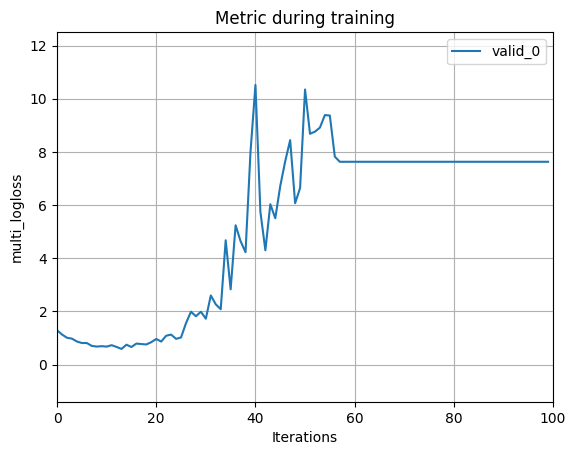

In [94]:
lgb.plot_metric(lgb_model)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      7609
           1       0.21      0.13      0.16       297
           2       0.00      0.00      0.00       125
           3       0.05      0.03      0.04       471
           4       0.98      0.99      0.99      9805
           5       0.11      0.20      0.14        55
           6       0.14      0.07      0.10       234
           7       0.28      0.11      0.16       806
           8       0.08      0.04      0.05       141
           9       0.44      0.13      0.20       642
          10       0.01      0.08      0.01        50
          11       0.60      0.84      0.70      3880
          12       0.87      0.99      0.93      7824
          13       0.62      0.25      0.35      1438
          14       0.04      0.04      0.04       719
          15       0.00      0.00      0.00         6

    accuracy                           0.80     34102
   

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


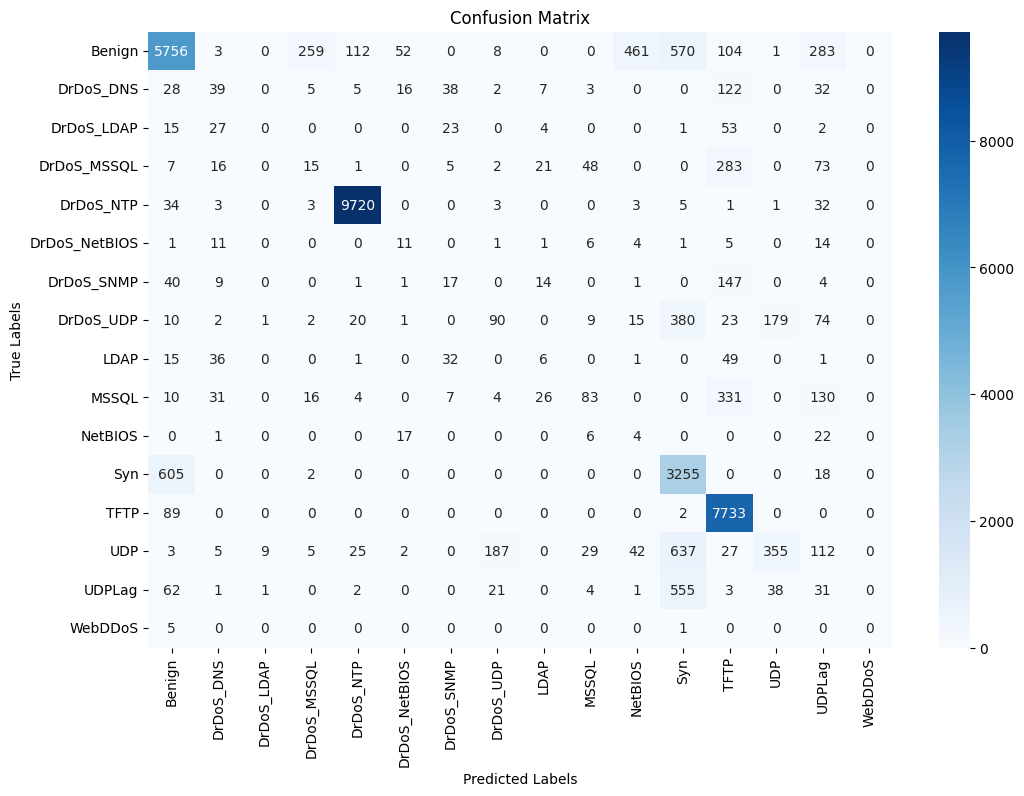

In [28]:
print("Classification Report:")
print(classification_report(y_test, lgb_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, lgb_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
lgb_params = {
    'objective': ['multiclass'],
    'num_class': [len(label_encoder.classes_)],
    'metric': ['multi_logloss'],
    'random_state': [42],
    'max_depth': [-1, 30, 50],
    'n_estimators': [100, 200],
    'min_child_samples': [7, 20, 30],
    'verbosity': [-1]
}

In [30]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

lgb_rs_cv = RandomizedSearchCV(
    estimator = lgb.LGBMClassifier(),
    param_distributions = lgb_params,
    cv = rskf,
    n_iter = 3,
    n_jobs = 2,
)

In [31]:
lgb_rscv_model = lgb_rs_cv.fit(X_train, y_train)

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
lgb.save(lgb_rscv_model, 'lgb_model.pkl')

In [99]:
lgb_rscv_pred = lgb_rscv_model.predict(X_test) # TODO 0.7951146560319042 was old value

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [100]:
accuracy_score(y_test, lgb_rscv_pred) # TODO 0.7951146560319042 was old value

0.6624831388188376

In [101]:
# convert from one-hot encoding to categorical
if lgb_rscv_pred.ndim > 1:
    lgb_rscv_pred = lgb_rscv_pred.argmax(axis=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62      7609
           1       0.21      0.04      0.07       297
           2       0.00      0.00      0.00       125
           3       0.00      0.00      0.00       471
           4       0.82      0.75      0.79      9805
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00       234
           7       0.00      0.00      0.00       806
           8       0.00      0.00      0.00       141
           9       0.42      0.02      0.04       642
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00      3880
          12       0.94      0.97      0.96      7824
          13       0.00      0.00      0.00      1438
          14       0.00      0.00      0.00       719
          15       0.00      0.00      0.00         6

    accuracy                           0.66     34102
   

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


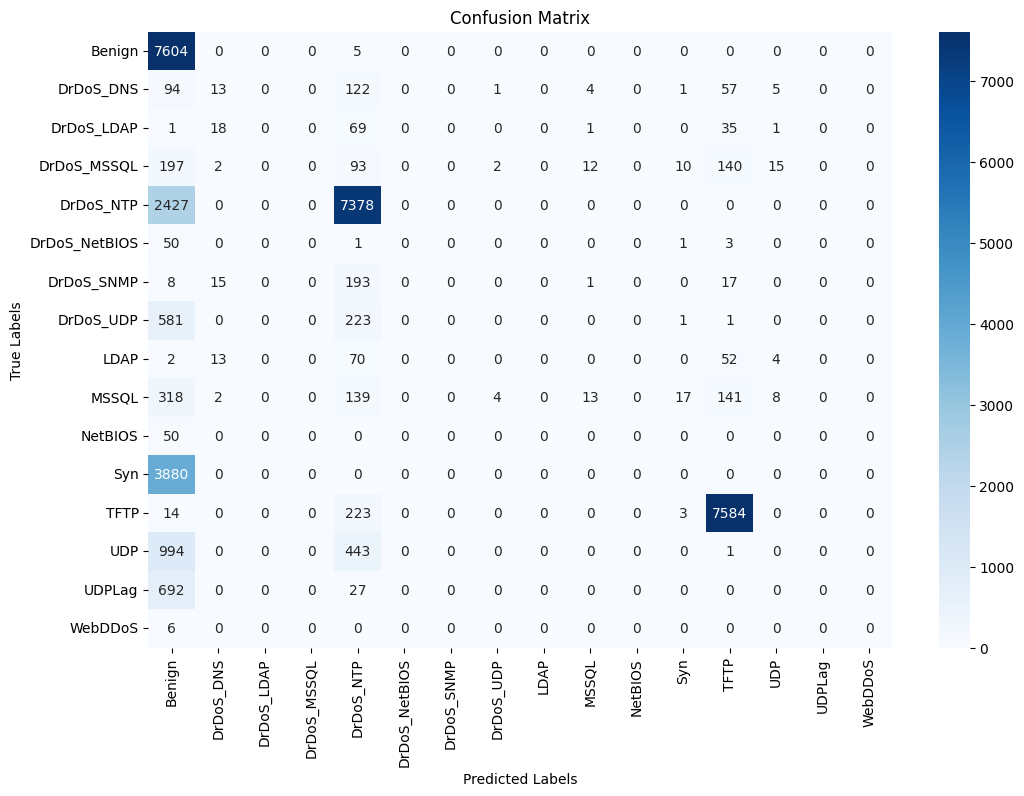

In [102]:
print("Classification Report:")
print(classification_report(y_test, lgb_rscv_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, lgb_rscv_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

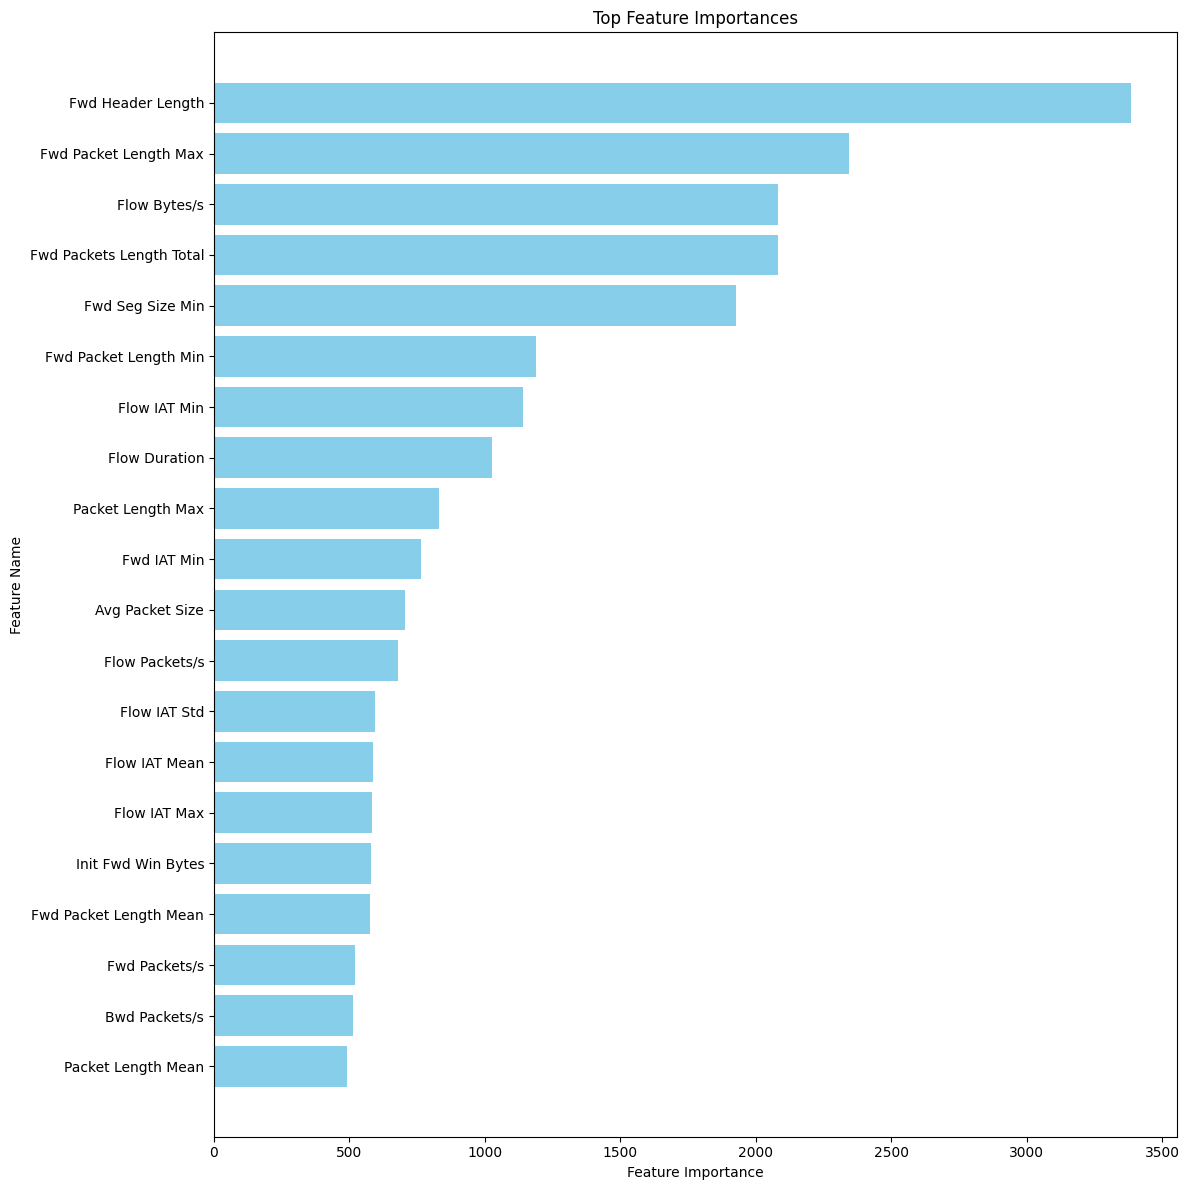

In [49]:
best_model = lgb_rs_cv.best_estimator_
importance = best_model.feature_importances_
# Create a DataFrame for sorting and visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot the top N most important features
top_n = 20  # Number of top features to display
plt.figure(figsize=(12, 12))
plt.barh(feature_importance_df['Feature'][:top_n][::-1], 
         feature_importance_df['Importance'][:top_n][::-1], 
         color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [45]:
best_model.feature_importances_

array([  91, 1025,  262,  114, 2081,  153, 2345, 1189,  575,  322,   53,
        120,  104,   77, 2083,  678,  586,  596,  584, 1140,  433,  274,
        211,  240,  764,  268,   99,   35,   47,  125,   33, 3385,  114,
        521,  512,  404,  831,  493,  150,   66,   29,    0,   96,   85,
         37,   56,  707,    0,    0,    0,    0,    0,    0,  581,  252,
        123, 1927,   51,   39,   33,   89,   80,   86,   88,  128],
      dtype=int32)

# LGBoost Reduced Dataset

In [61]:
# using the values from RF
low_val_feats = [
    'Flow Duration', 'Packet Length Std', 'Packet Length Variance', 'Bwd Packets/s', 'Protocol',
    'Idle Max', 'Subflow Bwd Packets', 'URG Flag Count', 'Init Bwd Win Bytes', 'Bwd IAT Total',
    'Bwd IAT Mean', 'Fwd Header Length', 'Total Backward Packets', 'Fwd Packet Length Std',
    'Fwd Seg Size Min', 'Bwd Header Length', 'Bwd Packet Length Max', 'Subflow Bwd Bytes',
    'Bwd IAT Max', 'Idle Std', 'Avg Bwd Segment Size', 'Fwd IAT Min', 'Bwd Packets Length Total',
    'Active Max', 'Idle Mean', 'Flow IAT Min', 'CWE Flag Count', 'Idle Min', 'Active Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Down/Up Ratio', 'Bwd IAT Std',
    'Bwd Packet Length Std', 'Active Mean', 'Fwd PSH Flags', 'RST Flag Count', 'Bwd IAT Min',
    'Active Std', 'SYN Flag Count'
]

In [62]:
for feat in low_val_feats:
    X_train.drop(feat, axis=1, inplace=True)
    X_test.drop(feat, axis=1, inplace=True)
    X_val.drop(feat, axis=1, inplace=True)

In [63]:
X_train.shape

(136404, 25)

In [66]:
lgb_params = {
    'objective': ['multiclass'],
    'num_class': [len(label_encoder.classes_)],
    'metric': ['multi_logloss'],
    'random_state': [42],
    'max_depth': [-1, 30, 50],
    'n_estimators': [100, 200],
    'min_child_samples': [7, 20, 30],
    'verbosity': [-1]
}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

lgb_red_rs_cv = RandomizedSearchCV(
    estimator = lgb.LGBMClassifier(),
    param_distributions = lgb_params,
    cv = rskf,
    n_iter = 3,
    n_jobs = 2,
)

In [67]:
lgb_red_rscv_model = lgb_red_rs_cv.fit(X_train, y_train)

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [70]:
lgb_red_rscv_pred = lgb_red_rscv_model.predict(X_test)

# convert from one-hot encoding to categorical
if lgb_red_rscv_pred.ndim > 1:
    lgb_red_rscv_pred = lgb_red_rscv_pred.argmax(axis=1)

accuracy_score(y_test, lgb_red_rscv_pred)

0.7790452172893085

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7609
           1       0.00      0.00      0.00       297
           2       0.00      0.00      0.00       125
           3       0.00      0.00      0.00       471
           4       0.80      0.97      0.88      9805
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00       234
           7       0.32      0.46      0.37       806
           8       0.00      0.00      0.00       141
           9       0.00      0.00      0.00       642
          10       0.00      0.00      0.00        50
          11       0.95      0.75      0.83      3880
          12       0.90      0.91      0.91      7824
          13       0.48      0.04      0.08      1438
          14       0.41      0.64      0.50       719
          15       0.00      0.00      0.00         6

    accuracy                           0.78     34102
   

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


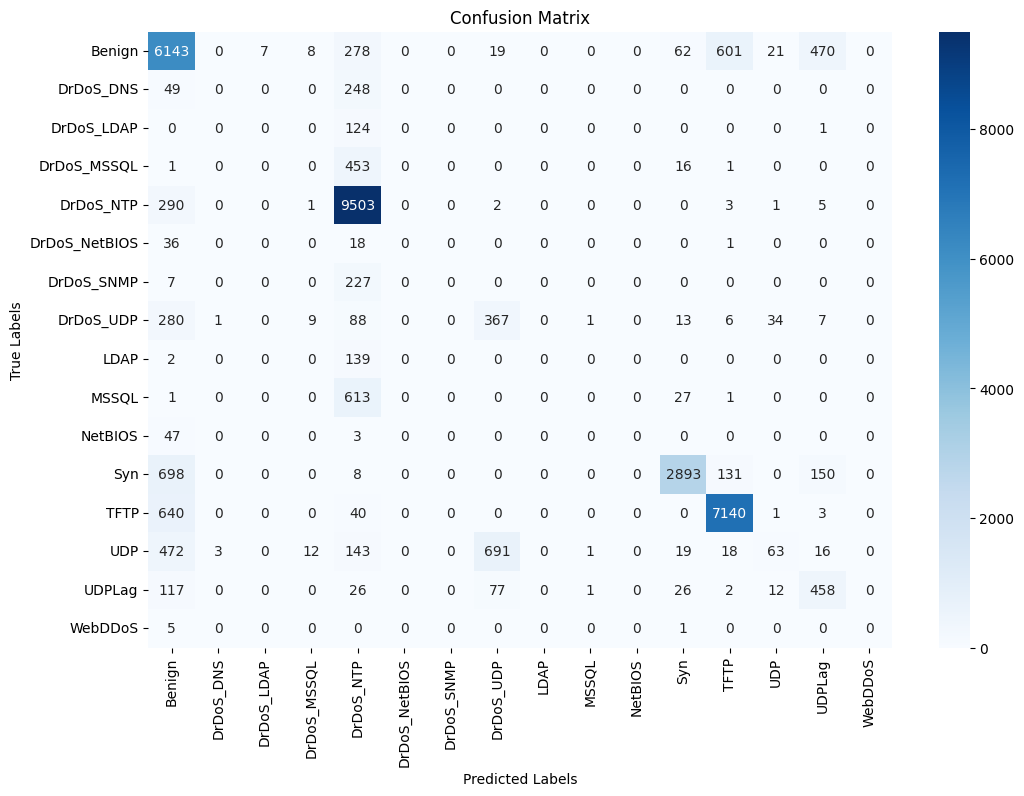

In [71]:
print("Classification Report:")
print(classification_report(y_test, lgb_red_rscv_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, lgb_red_rscv_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()